<a href="https://colab.research.google.com/github/bubs-04/credit-risk-project/blob/main/credit_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:50:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model Performance (Threshold: 0.4) ---
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       141
           1       0.56      0.63      0.59        59

    accuracy                           0.74       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.75      0.74      0.75       200



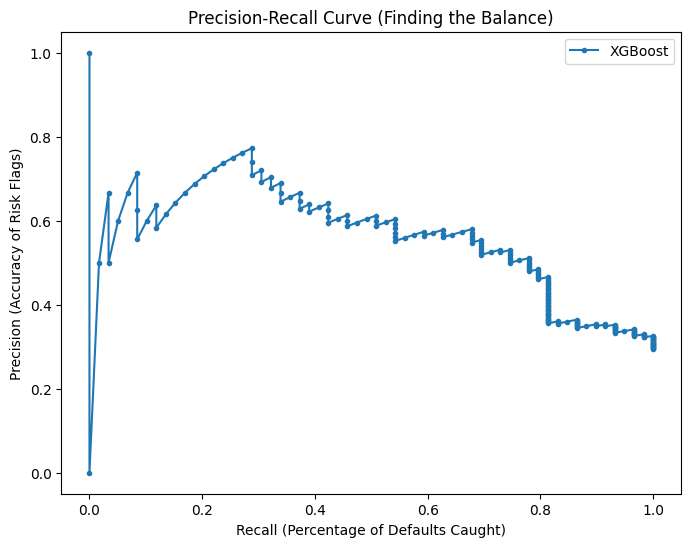

In [1]:
# ==========================================
# German Credit Risk Prediction (Portfolio Project)
# Goal: Minimize financial loss by predicting loan defaults
# Tools: Python, Pandas, XGBoost, Scikit-Learn
# ==========================================

# 1. IMPORTS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 2. DATA LOADING
# Using the UCI Machine Learning Repository 'German Credit Data'
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
columns = ['Checking_Status', 'Duration', 'Credit_History', 'Purpose',
           'Credit_Amount', 'Savings', 'Employment', 'Installment_Rate',
           'Personal_Status', 'Guarantors', 'Residence_Since', 'Property',
           'Age', 'Other_Installments', 'Housing', 'Existing_Credits',
           'Job', 'Num_Dependents', 'Phone', 'Foreign_Worker', 'Risk']

# Load data (Separator is space, not comma)
df = pd.read_csv(url, sep=' ', names=columns)

# 3. PREPROCESSING
# Map Target: 1 (Good) -> 0, 2 (Bad) -> 1
# We want '1' to represent the Risk (The Default)
df['Risk'] = df['Risk'].map({1: 0, 2: 1})

# Feature Selection (Focusing on high-impact financial features)
features = ['Checking_Status', 'Duration', 'Credit_History', 'Purpose', 'Credit_Amount', 'Age', 'Risk']
df_subset = df[features]

# One-Hot Encoding (Converting text to machine-readable numbers)
df_clean = pd.get_dummies(df_subset, columns=['Checking_Status', 'Credit_History', 'Purpose'], drop_first=True)

# 4. TRAIN/TEST SPLIT
X = df_clean.drop('Risk', axis=1)
y = df_clean['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. MODELING (XGBoost)
# scale_pos_weight=3 tells the model: "Treat a Bad Loan as 3x more important than a Good Loan"
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=3, random_state=42)
model.fit(X_train, y_train)

# 6. BUSINESS OPTIMIZATION (Threshold Tuning)
# Standard predictions use a 50% cutoff. We want to be more conservative.
y_probs = model.predict_proba(X_test)[:, 1]

# We test a stricter threshold: 0.3 (If >30% probability of default, flag as Risk)
custom_threshold = 0.3
y_preds_optimized = (y_probs > custom_threshold).astype(int)

# 7. FINAL EVALUATION
print(f"--- Model Performance (Threshold: {custom_threshold}) ---")
print(classification_report(y_test, y_preds_optimized))

# Visualizing the Tradeoff
plt.figure(figsize=(8, 6))
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.title('Precision-Recall Curve (Finding the Balance)')
plt.xlabel('Recall (Percentage of Defaults Caught)')
plt.ylabel('Precision (Accuracy of Risk Flags)')
plt.legend()
plt.show()